In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from pysheds.grid import Grid
from pysheds.view import Raster
import skimage.morphology
import skimage.segmentation
from itertools import zip_longest, cycle, permutations
from scipy import ndimage
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
class Node:
    def __init__(self, name=None, parent=None, l=None, r=None, level=None, elev=None,
                 comm=None, t=None, vol=0, current_vol=0):
        self.name = name
        self.parent = parent
        self.l = l
        self.r = r
        self.t = t
        self.elev = elev
        self.comm = comm
        self.level = level
        self.vol = vol
        self.current_vol = current_vol

def marginal_vol(node):
    if node.l and node.r:
        if node.l is node.r:
            node.vol -= node.l.vol
            node.vol = max(node.vol, 0)
            marginal_vol(node.l)
        else:
            node.vol -= node.l.vol
            node.vol -= node.r.vol
            node.vol = max(node.vol, 0)
            marginal_vol(node.l)
            marginal_vol(node.r)
        
def enumerate_leaves(node, level=0, stack=[]):
    if node.level >= level:
        if node.name:
            stack.append(node.name)
        if node.l:
            enumerate_leaves(node.l, level=level, stack=stack)
        if node.r:
            enumerate_leaves(node.r, level=level, stack=stack)

def map_nodes(node, op=(lambda x: None), *args, **kwargs):
    if node.l:
        map_nodes(node.l, op=op, *args, **kwargs)
    if node.r:
        map_nodes(node.r, op=op, *args, **kwargs)
    op(node, *args, **kwargs)

def accumulate(x, accumulator):
    accumulator += (x.vol)
        
def get_root(node):
    if node.parent:
        return get_root(node.parent)
    else:
        return node

def show_tree(tree):
    depth = ""
    treestr = ""

    def print_push(char):
        nonlocal depth
        branch_str = ' {}  '.format(char)
        depth += branch_str

    def print_pop():
        nonlocal depth
        depth = depth[:-4]

    def print_tree(node):
        nonlocal depth
        nonlocal treestr
        if (node.l or node.r):
            if (node.name):
                treestr += '({0}-{1})\n'.format(node.level, node.name)
            else:
                treestr += '{0}{1}\n'.format(chr(9472), '+')
            treestr += '{0} {1}{2}{2}'.format(depth, chr(9500), chr(9472))
            print_push(chr(9474))
            print_tree(node.l)
            print_pop()
            treestr += '{0} {1}{2}{2}'.format(depth, chr(9492), chr(9472))
            print_push(' ')
            print_tree(node.r)
            print_pop()
        else:
            treestr += '({0}-{1})\n'.format(node.level, node.name)

    print_tree(tree)
    return treestr

def show_vol(tree):
    depth = ""
    treestr = ""

    def print_push(char):
        nonlocal depth
        branch_str = ' {}  '.format(char)
        depth += branch_str

    def print_pop():
        nonlocal depth
        depth = depth[:-4]

    def print_tree(node):
        nonlocal depth
        nonlocal treestr
        if (node.l or node.r):
            if (node.name):
                treestr += '({0:.2f})\n'.format(node.vol)
            else:
                treestr += '({0:.2f})\n'.format(node.vol)
            treestr += '{0} {1}{2}{2}'.format(depth, chr(9500), chr(9472))
            print_push(chr(9474))
            print_tree(node.l)
            print_pop()
            treestr += '{0} {1}{2}{2}'.format(depth, chr(9492), chr(9472))
            print_push(' ')
            print_tree(node.r)
            print_pop()
        else:
            treestr += '({0:.2f})\n'.format(node.vol)

    print_tree(tree)
    return treestr

def traverse(node):
    if node.l:
        traverse(node.l)
    if node.r:
        traverse(node.r)
    if node.parent:
        if node.name:
            elevdiff = node.parent.elev - dem[ws[node.level] == node.name]
            vol = abs(np.asscalar(elevdiff[elevdiff > 0].sum()) * x * y)
            node.vol = vol
#            print(node.level, node.name, node.vol, node.parent.elev)
        else:
            leaves = []
            enumerate_leaves(node, level=node.level, stack=leaves)
            elevdiff = node.parent.elev - dem[np.isin(ws[node.level], leaves)]
            vol = abs(np.asscalar(elevdiff[elevdiff > 0].sum()) * x * y)
            node.vol = vol
#            print(node.level, leaves, node.vol, node.parent.elev)

In [3]:
grid = Grid.from_raster('../data/roi_10m', data_name='dem')
x, y = abs(grid.affine.a), abs(grid.affine.e)

In [4]:
dem = grid.view('dem')[30:130, 280:350]

In [5]:
ix = np.arange(dem.size).reshape(dem.shape)
top = ix[0, :]
bottom = ix[-1, :]
left = ix[:, 0]
right = ix[:, -1]

holes = np.zeros(dem.shape)
for permutation in permutations([top, bottom, left, right], 3):
    mask = np.copy(dem)
    exterior = np.concatenate(permutation)
    mask.flat[exterior] = dem.max()
    seed = np.copy(mask)
    seed[1:-1, 1:-1] = dem.max()
    rec = skimage.morphology.reconstruction(seed, mask, method='erosion')
    holes[(rec - dem) > 0] = dem[(rec - dem) > 0]

# Not sure if this is needed
holes[0, :] = 0
holes[-1, :] = 0
holes[:, 0] = 0
holes[:, -1] = 0

In [6]:
max_levels = 100
levels = []
mask = np.where(holes == 0, holes.min(), holes)
seed = np.where(holes == 0, mask, holes.max())
rec = skimage.morphology.reconstruction(seed, mask, method='erosion')
levels.append(rec)

for _ in range(max_levels):
    diff = rec - mask
    holes = np.where(diff, holes, 0)
    mask = np.where(holes == 0, holes.min(), holes)
    seed = np.where(holes == 0, mask, holes.max())
    rec = skimage.morphology.reconstruction(seed, mask, method='erosion')
    if not rec.any():
        break
    levels.append(rec)
    
levels = levels[::-1]
levels.append(np.ones(dem.shape))

In [7]:
struct = np.ones((3,3), dtype=bool)

ns = []
for index, level in enumerate(levels):
    _level, _n = ndimage.label(level, structure=struct)
    levels[index] = _level
    ns.append(_n)

In [8]:
lup = {}
ct = {}
has_lower = []
for n in ns:
    has_lower.append(np.zeros(n + 1, dtype=bool))

for index in range(len(levels) - 1):
    labelmap = pd.Series(levels[index + 1][levels[index] != 0],
                         index=levels[index][levels[index] != 0]).groupby(level=0).first()
    lup[index] = dict(labelmap)
    ct[index] = dict(labelmap.value_counts())
    has_lower[index + 1][labelmap.unique()] = True

In [9]:
ws = []
for index in range(len(levels) - 1):
    mask = (has_lower[index + 1][levels[index + 1]])
    w = skimage.morphology.watershed(dem, levels[index],
                                     mask=mask, watershed_line=True)
    w = np.where(mask, w, -1)
    ws.append(w)
ws.append(levels[-1])

In [10]:
c = {}
inside = np.zeros(dem.shape, dtype=bool)
inside[1:-1, 1:-1] = True
for index in range(len(levels) - 1):
    c[index] = {}
    comm = np.flatnonzero((ws[index] == 0) & inside)
    neighbors = ws[index].flat[grid._select_surround_ravel(comm, ws[index].shape)]
    comms = dict(zip(comm, [set() for i in comm]))
    for region in lup[index].keys():
        for elem in comm[(neighbors == region).any(axis=1)]:
            comms[elem].add(region)       
    for elem in comms:
        comms[elem] = tuple(comms[elem])
    for comm, pair in comms.items():
        if len(pair) > 2:
            for permutation in permutations(pair, 2):
                subpair = tuple(sorted(permutation))
                if subpair in c[index]:
                    if dem.flat[comm] < dem.flat[c[index][subpair]]:
                        c[index][subpair] = comm
                else:
                    c[index][subpair] = comm
        else:
            if pair in c[index]:
                if dem.flat[comm] < dem.flat[c[index][pair]]:
                    c[index][pair] = comm
            else:
                c[index][pair] = comm

In [11]:
level = []
subnum = []
full = []
n_i = 0

for index, n in enumerate(ns):
    s = np.arange(1, n + 1)
    f = s + n_i
    l = np.repeat(index, n)
    subnum.append(s)
    full.append(f)
    level.append(l)
    n_i += n
level = np.concatenate(level)
subnum = np.concatenate(subnum)
full = np.concatenate(full)
df = pd.DataFrame(np.column_stack([level, subnum]), index=full)

In [12]:
nodes = []
for index in range(len(levels)):
    nodes.append({})
    for i in range(1, ns[index] + 1):
        nodes[index][i] = Node(name=i, level=index)

In [13]:
# Figure out where each drop will end
drop = skimage.morphology.watershed(dem, np.where(ws[0] > 0, ws[0], 0), mask=ws[1] > 0)
for index in range(1, len(ws) - 1):
    num_lower = sum(ns[:index])
    base = drop + np.where((ws[index] > 0) & (drop == 0), num_lower + ws[index], 0)
    drop = skimage.morphology.watershed(dem, base, mask=ws[index + 1] > 0)

In [14]:
t = {}

for index in c:
    t[index] = {}
    for pair in c[index]:
        i, j = pair
        comm = c[index][pair]
        comm_elev = dem.flat[comm]
        neighbors = grid._select_surround_ravel(comm, dem.shape)
        ser = pd.DataFrame(np.column_stack([neighbors, dem.flat[neighbors], ws[index].flat[neighbors]]))
        ser = ser[ser[2].isin(list(pair))]
        g = ser.groupby(2).idxmin()[1].apply(lambda x: ser.loc[x, 0])
        fullix = drop.flat[g.values.astype(int)]
        lv = df.loc[fullix][0].values
        nm = df.loc[fullix][1].values
        g = pd.DataFrame(np.column_stack([lv, nm]), index=g.index.values.astype(int),
                         columns=['level', 'name']).to_dict(orient='index')
        gi = g.pop(i)
        gj = g.pop(j)
        gi['elev'] = comm_elev
        gj['elev'] = comm_elev
        # Might be overwriting when using update
#        g[j] = {}
#        g[i] = {}
        g[(j, i)] = gi
        g[(i, j)] = gj
        t[index].update(g)

In [15]:
for index in range(len(levels) - 1):
    g = set(range(1, ns[index] + 1))
    s = pd.DataFrame(pd.Series(c[index]))
    s[0] = s[0].astype(int)
    s[1] = dem.flat[s[0].values]
    s[2] = [lup[index][i] for i in s.index.get_level_values(0)]
    s = s.sort_values(1)
    num_connections = dict(s.groupby(2).size())
    
    for i in s.index:
        l = nodes[index][i[0]]
        r = nodes[index][i[1]]
        # Kind of ugly, but need to make sure both haven't been added already
        if not (get_root(l) is get_root(r)):
            parent = Node()
            parent.comm = s.loc[i, 0]
            parent.elev = s.loc[i, 1]
            parent.level = index
            upper_label = int(s.loc[i, 2])
            # Join watersheds at same level
            for j, d in zip(i, ('l', 'r')):
                g.discard(j)
                child = get_root(nodes[index][j])
                child.parent = parent
                setattr(parent, d, child)
            num_connections[upper_label] -= 1
            # If all watersheds in the depressions have been joined, move up
            if num_connections[upper_label] == 0:
                parent.level = (index + 1)
                parent.name = upper_label
                nodes[index + 1][parent.name] = parent
        else:
            num_connections[upper_label] -= 1
    if g:
        for j in g:
            upper_label = lup[index][j]
            child = nodes[index][j]
            parent = nodes[index + 1][upper_label]
            parent.elev = np.asscalar(dem[levels[index + 1] == upper_label].min())
            child.parent = parent
            parent.l = child
            parent.r = child
            nodes[index][j] = child
            nodes[index + 1][parent.name] = parent
            
traverse(nodes[-1][1])
nodes[-1][1].vol = np.inf

In [16]:
for index in t:
    for pair, transfer in t[index].items():
        i, j = pair
        lv = transfer['level']
        nm = transfer['name']
        el = transfer['elev']
        node = nodes[index][i]
        if node.t:
            if el < node.t.parent.elev:
                node.t = nodes[lv][nm]
        else:
            node.t = nodes[lv][nm]

In [17]:
print(show_tree(nodes[-1][1]))

(5-1)
 ├──(4-1)
 └───+
     ├──(4-3)
     └───+
         ├───+
         │   ├──(4-5)
         │   └───+
         │       ├──(4-2)
         │       │   ├───+
         │       │   │   ├──(3-2)
         │       │   │   └──(3-3)
         │       │   └───+
         │       │       ├──(3-1)
         │       │       │   ├──(2-1)
         │       │       │   └───+
         │       │       │       ├──(2-2)
         │       │       │       └───+
         │       │       │           ├───+
         │       │       │           │   ├──(2-3)
         │       │       │           │   └──(2-4)
         │       │       │           │       ├──(1-1)
         │       │       │           │       └───+
         │       │       │           │           ├──(1-2)
         │       │       │           │           │   ├──(0-1)
         │       │       │           │           │   └──(0-2)
         │       │       │           │           └──(1-3)
         │       │       │           └──(2-5)
         │       │       └

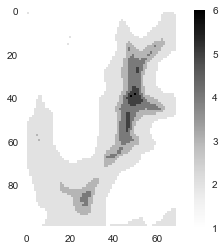

In [18]:
plt.imshow(sum([(level > 0).astype(int) for level in levels]), zorder=1)
plt.colorbar()

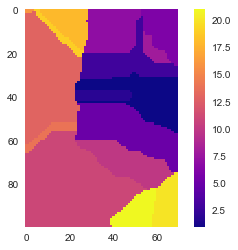

In [19]:
plt.imshow(drop, zorder=1, cmap='plasma')
plt.colorbar()

In [20]:
v = pd.DataFrame(np.column_stack([level.ravel(), region.ravel(), 0.1*900*dropmask.ravel()])).groupby([0,1]).sum().reset_index()
v

,0,1,2
0,0.0,1.0,55620.0
1,0.0,2.0,11520.0
2,1.0,1.0,43290.0
3,1.0,3.0,71640.0
4,2.0,1.0,27270.0
5,2.0,2.0,40770.0
6,2.0,3.0,7920.0
7,2.0,5.0,43830.0
8,2.0,6.0,148500.0
9,3.0,2.0,98370.0


In [20]:
print(show_vol(nodes[-1][1]))

(inf)
 ├──(14220.04)
 └──(937850231.25)
     ├──(1709.91)
     └──(303150290.62)
         ├──(296845087.50)
         │   ├──(1506961.67)
         │   └──(144919068.75)
         │       ├──(124693832.81)
         │       │   ├──(629.85)
         │       │   │   ├──(269.93)
         │       │   │   └──(359.91)
         │       │   └──(27131632.03)
         │       │       ├──(6947893.65)
         │       │       │   ├──(810.02)
         │       │       │   └──(2456098.90)
         │       │       │       ├──(1979.85)
         │       │       │       └──(2188513.92)
         │       │       │           ├──(1998982.18)
         │       │       │           │   ├──(629.96)
         │       │       │           │   └──(1998352.44)
         │       │       │           │       ├──(5400.00)
         │       │       │           │       └──(1014206.18)
         │       │       │           │           ├──(187828.91)
         │       │       │           │           │   ├──(1349.95)
         │       │

In [21]:
marginal_vol(nodes[-1][1])

In [22]:
print(show_vol(nodes[-1][1]))

(inf)
 ├──(14220.04)
 └──(634698230.71)
     ├──(1709.91)
     └──(6304753.02)
         ├──(150419057.08)
         │   ├──(1506961.67)
         │   └──(19695496.07)
         │       ├──(97561570.94)
         │       │   ├──(0.00)
         │       │   │   ├──(269.93)
         │       │   │   └──(359.91)
         │       │   └──(12644179.98)
         │       │       ├──(4490984.73)
         │       │       │   ├──(810.02)
         │       │       │   └──(265605.14)
         │       │       │       ├──(1979.85)
         │       │       │       └──(183052.00)
         │       │       │           ├──(0.00)
         │       │       │           │   ├──(629.96)
         │       │       │           │   └──(978746.26)
         │       │       │           │       ├──(5400.00)
         │       │       │           │       └──(668428.31)
         │       │       │           │           ├──(186298.96)
         │       │       │           │           │   ├──(1349.95)
         │       │       │        

In [25]:
# Why is one of them negative?

In [ ]:
runoff = 55620.0
node = nodes[0][1]
capacity = node.vol - node.current_vol
transfer = min(runoff, capacity)
runoff -= transfer
node.current_vol += transfer

while runoff > 0:
    parent = node.parent
    # Need to check if left and right are the same node
    if parent.l is not parent.r:
        if node is parent.l:
            sibling = parent.r
        else:
            sibling = parent.l
        # TODO: This actually needs to be applied recursively
        node = sibling
        capacity = node.vol - node.current_vol
        transfer = min(runoff, capacity)
        runoff -= transfer
        node.current_vol += transfer
        if runoff <= 0:
            break
    node = parent
    capacity = node.vol - node.current_vol
    transfer = min(runoff, capacity)
    runoff -= transfer
    node.current_vol += transfer
    if runoff <= 0:
        break    

In [45]:
#overflow = {}
#overflow[len(levels) - 1] = np.ones(dem.shape, dtype=int)
#overflow[len(levels) - 2] = skimage.morphology.watershed(dem, ws[-2],
#                                                        watershed_line=False)
#for index in range(len(levels) - 2)[::-1]:
#    over = np.zeros(dem.shape)
#    for upper in np.flatnonzero(has_lower[index + 1]):
#        feature = np.where(ws[index] > 0, ws[index], 0)
#        mask = (ws[index + 1] == upper)
#        w = skimage.morphology.watershed(dem, feature, mask=mask,
#                                         watershed_line=False)
#        over += np.where(mask, w, 0)
#    overflow[index] = drop

In [46]:
#index = 1
#over = np.zeros(dem.shape)
#for upper in np.flatnonzero(has_lower[index + 1]):
#    feature = np.where(ws[index] > 0, ws[index], 0)
#    mask = (ws[index + 1] == upper)
#    w = skimage.morphology.watershed(dem, feature, mask=mask,
#                                         watershed_line=False)
#    over += np.where(mask, w, 0)

In [12]:
# Recompute watersheds without line
#ws = []
#
#for index in range(len(levels) - 1):
#    mask = (has_lower[index + 1][levels[index + 1]])
#    w = skimage.morphology.watershed(dem, levels[index],
#                                     mask=mask, watershed_line=False)
#    w = np.where(mask, w, -1)
#    ws.append(w)
#ws.append(levels[-1])

In [13]:
# Figure out where each drop will end up
#dropmap = {}
#dropmap[len(levels) - 1] = np.ones(dem.shape, dtype=int)
#dropmap[len(levels) - 2] = skimage.morphology.watershed(dem, ws[-2],
#                                                        watershed_line=False)
#for index in range(len(levels) - 2)[::-1]:
#    drop = np.zeros(dem.shape)
#    for upper in np.flatnonzero(has_lower[index + 1]):
#        feature = np.where(ws[index] > 0, ws[index], 0)
#        mask = (dropmap[index + 1] == upper)
#        w = skimage.morphology.watershed(dem, feature, mask=mask,
#                                         watershed_line=False)
#        drop += np.where(mask, w, 0)
#    dropmap[index] = drop
#    
#dropmask = np.ones(dem.shape)
#level = np.zeros(dem.shape)
#region = np.zeros(dem.shape)
#for index in range(len(levels))[::-1]:
#    select = (dropmap[index] > 0)
#    level[select] = index
#    region[select] = dropmap[index][select]